# Modelo 1:

- Creación de Subconjuntos de Entrenamiento

Ventanas Deslizantes: Se implementa una función create_training_data() que crea subconjuntos de entrada-salida utilizando ventanas deslizantes sobre la serie temporal.
Parámetros: El tamaño de la ventana de entrada (input_length = 30) y el tamaño de la ventana de salida (output_length = 15) se definen, lo cual determina la longitud de las secuencias para el modelo.
División en Conjuntos de Entrenamiento y Prueba: Los datos generados se dividen en entrenamiento (80%) y prueba (20%).

* Definición de la Arquitectura de la GAN

Generador (Generator):
Función Principal: Utiliza una LSTM para recibir la secuencia de entrada y generar datos de salida que deberían imitar los datos reales. Utiliza funciones de activación ReLU y Tanh para aprender patrones complejos y ajustarse a las limitaciones de los valores normalizados.
Objetivo: Rellenar los "huecos" en la serie temporal o completar la información faltante con datos generados de forma realista.
Discriminador (Discriminator):
Función Principal: También utiliza una LSTM y tiene como salida un valor de probabilidad mediante una función Sigmoid para determinar si los datos de salida son reales o falsos.
Objetivo: Evaluar si los datos generados por el Generador son plausibles en comparación con los datos reales.

* Entrenamiento de la GAN

Configuración de Optimización: Se utilizan optimizadores Adam con una tasa de aprendizaje de 0.001 para ambos modelos (Generador y Discriminador).
Pérdida del Discriminador (BCELoss):
Entrenamiento con Datos Reales y Falsos: El Discriminador se entrena primero con datos reales, clasificándolos correctamente, y luego con los datos falsos generados por el Generador. Se actualizan los pesos para mejorar su capacidad de diferenciación.
Pérdida del Generador (BCELoss y MSE):
Pérdida Adversarial: El Generador trata de engañar al Discriminador para que clasifique los datos generados como reales.
Pérdida de Reconstrucción (MSE): Además de la pérdida adversarial, también se calcula el error cuadrático medio (MSE) entre los datos generados y los datos reales esperados, lo cual ayuda a que la salida sea lo más precisa posible.
Condición de Early Stopping: Se implementa una clase de EarlyStopping para detener el entrenamiento si la pérdida del Generador no mejora tras un número determinado de épocas (10 épocas de paciencia).

* Validación del Modelo

Evaluación del Generador: Después del entrenamiento, se utiliza el modelo para predecir los valores de salida para el conjunto de prueba (X_test).
Cálculo de Métricas: Se calculan las métricas de error (MSE, MAE) y el coeficiente de determinación (R2 Score) para evaluar la calidad de las predicciones.
Generación de Nuevos Datos para la Serie Temporal

Generación a Partir de Ventana Específica: El Generador se utiliza para predecir la continuación de una secuencia dada, tomando un subconjunto específico de la serie temporal.
Visualización: Finalmente, se grafican los datos originales junto con los datos generados para visualizar la interpolación realizada por la GAN.

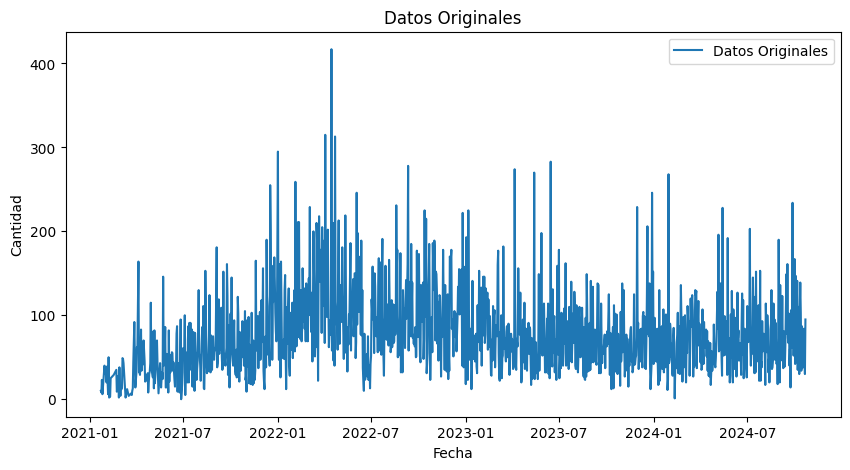

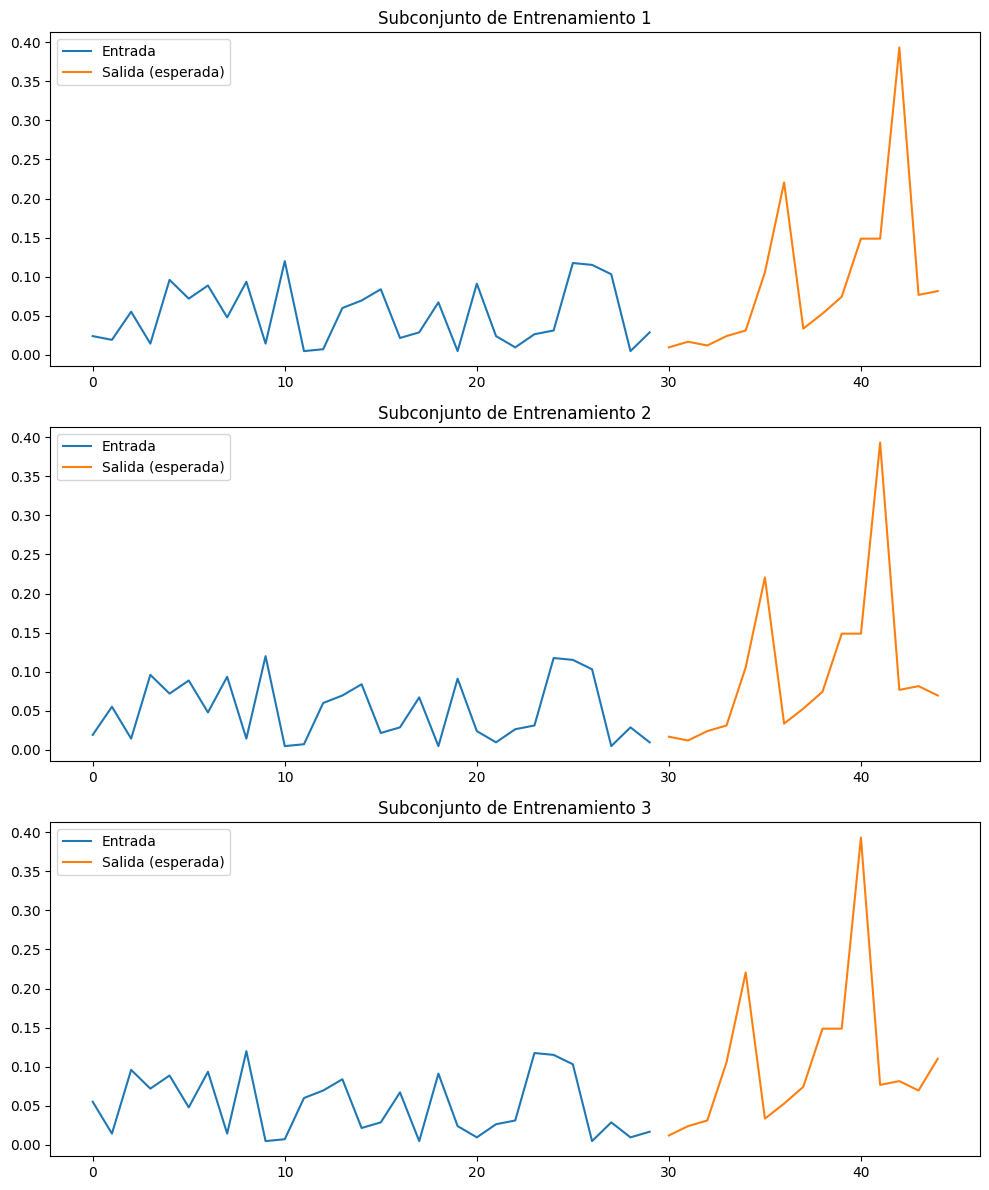

Epoch [10/300], d_loss: 1.3832, g_loss: 0.7403
Early stopping triggered at epoch 11
MSE en datos de prueba: 3967.1890
MAE en datos de prueba: 45.7295
R2 Score en datos de prueba: -0.5601


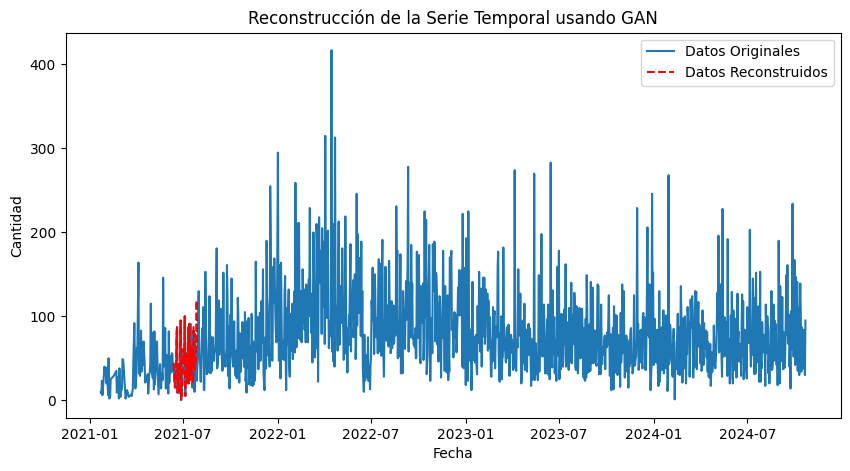

In [ ]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los datos de la empresa
file_path = '/content/Consolidada_depurada.xlsx'
df_plasticos = pd.read_excel(file_path)

# Los datos están ordenados por fecha
df_plasticos['FECHA'] = pd.to_datetime(df_plasticos['FECHA'])
df_plasticos = df_plasticos.sort_values('FECHA')

# Escalar los datos
x = df_plasticos['Cantidad'].values
x_min, x_max = x.min(), x.max()
x_normalized = (x - x_min) / (x_max - x_min)

# Visualizar los datos originales
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.title("Datos Originales")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Crear subconjuntos de entrenamiento con ventanas deslizantes específicas
def create_training_data(series, input_length, output_length):
    X, y = [], []
    for start in range(0, len(series) - input_length - output_length + 1):
        input_seq = series[start: start + input_length]
        output_seq = series[start + input_length: start + input_length + output_length]
        X.append(input_seq)
        y.append(output_seq)
    return np.array(X), np.array(y)

# Utilizar los datos normalizados de la serie temporal real
time_series = x_normalized

# Crear pares de entrada-salida
input_length = 30  # Incrementar el tamaño de la ventana de entrada para un mejor aprendizaje
output_length = 15  # Ajustar el tamaño de la salida
X, y = create_training_data(time_series, input_length, output_length)

# Visualizar algunos de los subconjuntos generados
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
for i in range(3):
    ax[i].plot(np.arange(input_length), X[i], label="Entrada")
    ax[i].plot(np.arange(input_length, input_length + output_length), y[i], label="Salida (esperada)")
    ax[i].set_title(f"Subconjunto de Entrenamiento {i+1}")
    ax[i].legend()
plt.tight_layout()
plt.show()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir los datos a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, input_length, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, output_length, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, input_length, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, output_length, 1)

# Definir clases de generador y discriminador para GAN mejorada con LSTM
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_layers=1):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=1):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Inicializar modelos, optimizadores y funciones de pérdida
input_dim = 1
output_dim = output_length
generator = Generator(input_dim=input_dim, output_dim=output_dim)
discriminator = Discriminator(input_dim=1)

optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)
loss_function = nn.BCELoss()
loss_function_mse = nn.MSELoss()

# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

# Ciclo de entrenamiento
num_epochs = 300
for epoch in range(num_epochs):
    # Entrenar el Discriminador
    optimizer_D.zero_grad()
    real_labels = torch.ones(X_train.size(0), 1)
    fake_labels = torch.zeros(X_train.size(0), 1)
    real_data = y_train
    real_outputs = discriminator(real_data)
    d_loss_real = loss_function(real_outputs, real_labels)
    z = X_train
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    d_loss_fake = loss_function(fake_outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    # Entrenar el Generador
    optimizer_G.zero_grad()
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    g_loss_adversarial = loss_function(fake_outputs, real_labels)
    y_train_adjusted = y_train.view(-1, output_length)
    g_loss_mse = loss_function_mse(fake_data.squeeze(-1), y_train_adjusted)
    g_loss = g_loss_adversarial + g_loss_mse
    g_loss.backward()
    optimizer_G.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Verificar si el entrenamiento debe detenerse por early stopping
    if early_stopping.should_stop(g_loss.item()):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# Validación del modelo
with torch.no_grad():
    z_test = X_test
    reconstructed_data = generator(z_test).detach().numpy().flatten()
    reconstructed_data = reconstructed_data * (x_max - x_min) + x_min
    y_test_unscaled = y_test.view(-1).numpy() * (x_max - x_min) + x_min

    mse = mean_squared_error(y_test_unscaled, reconstructed_data)
    mae = mean_absolute_error(y_test_unscaled, reconstructed_data)
    r2 = r2_score(y_test_unscaled, reconstructed_data)

    print(f"MSE en datos de prueba: {mse:.4f}")
    print(f"MAE en datos de prueba: {mae:.4f}")
    print(f"R2 Score en datos de prueba: {r2:.4f}")

# Generar nuevos datos utilizando una ventana del conjunto de prueba
start_idx = 100
end_idx = start_idx + input_length
z = torch.tensor(time_series[start_idx:end_idx], dtype=torch.float32).view(1, -1, 1)
interpolated_data = generator(z).detach().numpy().flatten()
interpolated_data = interpolated_data * (x_max - x_min) + x_min

# Graficar los resultados
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.plot(df_plasticos['FECHA'][start_idx:end_idx + output_length],
         np.concatenate((x[start_idx:start_idx + input_length], interpolated_data)),
         label="Datos Reconstruidos", linestyle='--', color='red')
plt.title("Reconstrucción de la Serie Temporal usando GAN")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()


# Modelo 2

El código implementa una Red Generativa Adversarial (GAN) mejorada con LSTM para la reconstrucción de una serie temporal de ventas de plásticos. La GAN consta de dos componentes principales: el Generador y el Discriminador, ambos diseñados para trabajar con secuencias temporales.

* Generador: El generador está compuesto por una red LSTM de dos capas con 128 unidades ocultas cada una. Su propósito es recibir una pequeña ventana de datos de entrada y generar una secuencia de salida que intente reconstruir los datos reales. La salida de la LSTM pasa por capas densas para ajustar la dimensión y se activa con funciones ReLU y Tanh para darle continuidad y limitar los valores generados.

* Discriminador: El discriminador tiene una arquitectura similar al generador, con una red LSTM de dos capas y 128 unidades ocultas, seguida de capas densas. La función de salida del discriminador utiliza Sigmoid para clasificar las secuencias como reales (1) o falsas (0). Utiliza LeakyReLU para evitar problemas de saturación durante el entrenamiento.

* Optimización y Pérdidas: Ambos modelos se entrenan usando el optimizador Adam con una tasa de aprendizaje reducida (0.0005) para una convergencia estable. El discriminador utiliza la pérdida binaria de entropía cruzada (BCELoss) para distinguir entre secuencias reales y generadas. El generador combina una pérdida adversarial (BCELoss) con una pérdida de reconstrucción (MSELoss) ponderada con un factor de 10 para mejorar tanto la plausibilidad de las secuencias como su fidelidad a los datos reales.

* Entrenamiento: El entrenamiento se realiza durante un máximo de 500 épocas, con un mecanismo de Early Stopping con paciencia de 20 épocas si no se observa una mejora significativa. En cada época, el discriminador se entrena primero con datos reales y luego con datos generados, mientras que el generador intenta mejorar para engañar al discriminador y minimizar el error de reconstrucción.

* Validación: Después del entrenamiento, el generador se utiliza para reconstruir la serie temporal completa a partir de la ventana de entrada. Se evalúa el rendimiento utilizando MSE, MAE, y R² para cuantificar la calidad de la reconstrucción. Además, se grafican tanto los datos originales como los generados para una validación visual.

* Conclusión: La arquitectura está diseñada para aprender patrones temporales complejos, utilizando LSTMs para capturar la dependencia temporal y capas densas para ajustar la salida. Los hiperparámetros, como la tasa de aprendizaje y la combinación de pérdidas, se eligen para estabilizar el proceso de entrenamiento, mejorando así la precisión de la reconstrucción de la serie temporal.

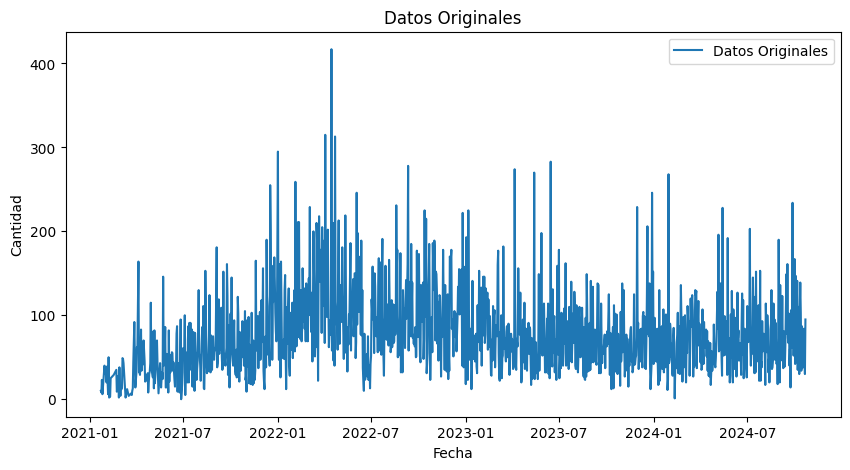

Epoch [10/500], d_loss: 1.3842, g_loss: 1.2247
Epoch [20/500], d_loss: 1.3769, g_loss: 1.1151
Epoch [30/500], d_loss: 1.4748, g_loss: 0.9843
Epoch [40/500], d_loss: 1.4285, g_loss: 0.7251
Epoch [50/500], d_loss: 1.3988, g_loss: 0.7272
Epoch [60/500], d_loss: 1.3916, g_loss: 0.7052
Epoch [70/500], d_loss: 1.3870, g_loss: 0.6979
Epoch [80/500], d_loss: 1.3843, g_loss: 0.6975
Epoch [90/500], d_loss: 1.3810, g_loss: 0.7027
Early stopping triggered at epoch 92


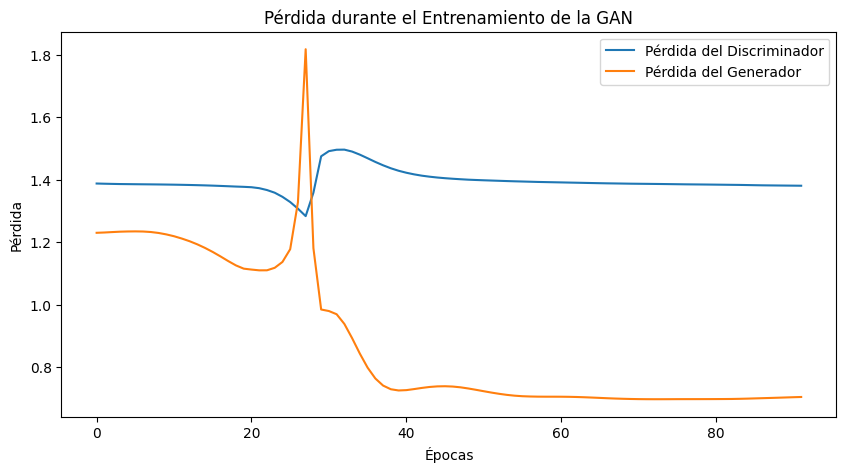

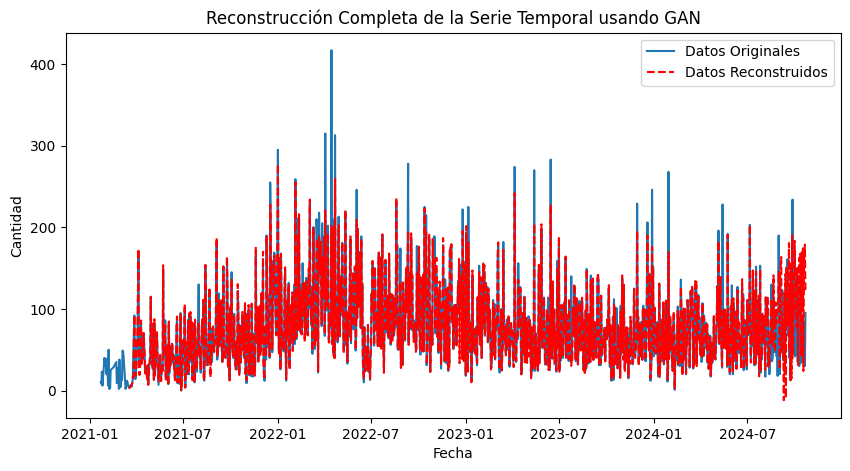

MSE en datos de prueba: 336.4933
MAE en datos de prueba: 6.9214
R2 Score en datos de prueba: 0.8605


In [ ]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los datos desde el excel de la empresa
file_path = '/content/Consolidada_depurada.xlsx'
df_plasticos = pd.read_excel(file_path)

# Datos ordenados por fecha
df_plasticos['FECHA'] = pd.to_datetime(df_plasticos['FECHA'])
df_plasticos = df_plasticos.sort_values('FECHA')

# Escalar los datos
x = df_plasticos['Cantidad'].values
x_min, x_max = x.min(), x.max()
x_normalized = (x - x_min) / (x_max - x_min)

# Visualizar los datos originales
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.title("Datos Originales")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Crear subconjuntos de entrenamiento con ventanas deslizantes específicas
def create_training_data(series, input_length, output_length):
    X, y = [], []
    for start in range(0, len(series) - input_length + 1):
        input_seq = series[start: start + input_length]
        output_seq = series[start + input_length: start + input_length + output_length]
        if len(output_seq) == output_length:
            X.append(input_seq)
            y.append(output_seq)
    return np.array(X), np.array(y)

# Utilizar los datos normalizados de la serie temporal real
time_series = x_normalized

# Actualizar el enfoque para usar solo una pequeña ventana de entrada y reconstruir toda la serie
input_length = 30  # Reducir el tamaño de la ventana de entrada
output_length = len(time_series) - input_length  # Reconstruir el resto de la serie
X, y = create_training_data(time_series, input_length, output_length)

# Asegurarse de tener solo una ventana de entrada para la reconstrucción completa
X_train = X[:1]  # Utilizar solo la primera ventana como entrada
y_train = y[:1]  # Utilizar la salida correspondiente para entrenar

# Convertir los datos a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, input_length, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, output_length, 1)

# Definir clases de generador y discriminador para GAN mejorada con LSTM
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_layers=2):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Inicializar modelos, optimizadores y funciones de pérdida
input_dim = 1
output_dim = output_length
generator = Generator(input_dim=input_dim, output_dim=output_dim)
discriminator = Discriminator(input_dim=1)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005)  # Reducir la tasa de aprendizaje para mejorar la estabilidad
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0005)
loss_function = nn.BCELoss()
loss_function_mse = nn.MSELoss()

# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=20, min_delta=1e-4)

# Ciclo de entrenamiento
num_epochs = 500
metrics = {'d_loss': [], 'g_loss': []}  # Almacenar las métricas de pérdida para el entrenamiento

for epoch in range(num_epochs):
    # Entrenar el Discriminador
    optimizer_D.zero_grad()
    real_labels = torch.ones(X_train.size(0), 1)
    fake_labels = torch.zeros(X_train.size(0), 1)
    real_data = y_train
    real_outputs = discriminator(real_data)
    d_loss_real = loss_function(real_outputs, real_labels)
    z = X_train
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    d_loss_fake = loss_function(fake_outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    # Entrenar el Generador
    optimizer_G.zero_grad()
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    g_loss_adversarial = loss_function(fake_outputs, real_labels)
    g_loss_mse = loss_function_mse(fake_data.squeeze(-1), y_train.view(-1, output_length)) * 10  # Aumentar el peso de la pérdida MSE
    g_loss = g_loss_adversarial + g_loss_mse
    g_loss.backward()
    optimizer_G.step()

    # Almacenar las métricas de pérdida
    metrics['d_loss'].append(d_loss.item())
    metrics['g_loss'].append(g_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Verificar si el entrenamiento debe detenerse por early stopping
    if early_stopping.should_stop(g_loss.item()):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# Graficar las métricas de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(metrics['d_loss'], label='Pérdida del Discriminador')
plt.plot(metrics['g_loss'], label='Pérdida del Generador')
plt.title('Pérdida durante el Entrenamiento de la GAN')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Validación del modelo
with torch.no_grad():
    z_test = X_train
    reconstructed_data = generator(z_test).detach().numpy().flatten()
    reconstructed_data = reconstructed_data * (x_max - x_min) + x_min

    # Graficar los resultados
    plt.figure(figsize=(10, 5))
    plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
    plt.plot(df_plasticos['FECHA'][input_length:input_length + output_length],
             reconstructed_data, label="Datos Reconstruidos", linestyle='--', color='red')
    plt.title("Reconstrucción Completa de la Serie Temporal usando GAN")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.show()

    # Evaluar las métricas para la reconstrucción
    y_true = x[input_length:input_length + output_length]
    mse = mean_squared_error(y_true, reconstructed_data)
    mae = mean_absolute_error(y_true, reconstructed_data)
    r2 = r2_score(y_true, reconstructed_data)

    print(f"MSE en datos de prueba: {mse:.4f}")
    print(f"MAE en datos de prueba: {mae:.4f}")
    print(f"R2 Score en datos de prueba: {r2:.4f}")


# Modelo 3

Este código implementa una Red Generativa Adversarial (GAN) con LSTM para la reconstrucción de series temporales, utilizando un enfoque donde el generador toma unos pocos puntos conocidos de una ventana temporal y genera el resto de la secuencia. Primero, los datos de ventas se cargan desde un archivo Excel, se ordenan por fecha y se normalizan entre 0 y 1 para mejorar la estabilidad del entrenamiento. La serie temporal se divide en ventanas deslizantes de tamaño fijo (30 puntos cada una), y luego se separan en conjuntos de entrenamiento y prueba, asegurando que el modelo aprenda a partir de secuencias consecutivas y pueda ser evaluado en datos no vistos.

El generador es una red LSTM de dos capas con 128 unidades ocultas cada una, seguido de una capa fully connected que proyecta la salida a una dimensión que corresponde al tamaño de la secuencia objetivo (25 puntos) usando funciones de activación ReLU y Tanh. El generador tiene un dropout del 30% para prevenir el sobreajuste. Por otro lado, el discriminador también es una LSTM de dos capas con 128 unidades ocultas y una capa densa con activación LeakyReLU, seguida de una sigmoide para clasificar las secuencias como reales o generadas. Ambos modelos utilizan redes LSTM porque están bien adaptadas para capturar patrones temporales en secuencias de datos.

Para el entrenamiento, los hiperparámetros clave incluyen una tasa de aprendizaje de 0.0005 y el uso del optimizador Adam, adecuado para estabilizar el proceso adversarial propio de las GANs. La función de pérdida del discriminador es la entropía cruzada binaria (BCELoss), mientras que el generador utiliza una combinación de pérdidas: una pérdida adversarial (BCELoss) y una pérdida de reconstrucción (MSELoss) ponderada con un factor de 10 para asegurar que los valores generados sean similares a los reales. El proceso de entrenamiento se realiza durante 200 épocas o hasta que el early stopping detenga el proceso, si no se observa una mejora significativa durante 20 épocas consecutivas.

El entrenamiento se realiza en dos pasos: primero se entrena el discriminador con datos reales y luego con datos generados, para fortalecer su capacidad de distinguir entre ambos. Luego se entrena el generador para que pueda engañar al discriminador, haciendo que las secuencias generadas se clasifiquen como reales. Durante la validación, el generador se prueba con ventanas de datos de prueba, donde recibe 5 puntos aleatorios y debe reconstruir los 25 puntos restantes. Estas reconstrucciones se visualizan comparando los valores reales y generados.

En resumen, este código implementa una GAN con LSTM para la reconstrucción de series temporales. Utiliza un enfoque donde se presentan pocos puntos de la serie y se genera el resto de la ventana, lo cual mejora la capacidad del modelo de generalizar a partir de datos parciales. La arquitectura con LSTM permite al modelo aprender patrones temporales complejos, y la combinación de pérdidas asegura tanto la calidad de la reconstrucción como la plausibilidad de los datos generados. La implementación de early stopping y el enfoque cuidadoso en los hiperparámetros aseguran un entrenamiento estable y evitan problemas comunes en el proceso adversarial, como el sobreajuste o la falta de convergencia.

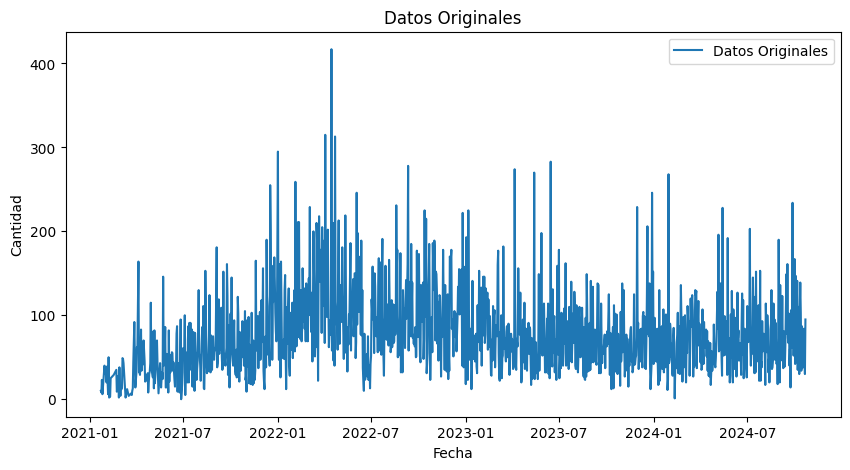

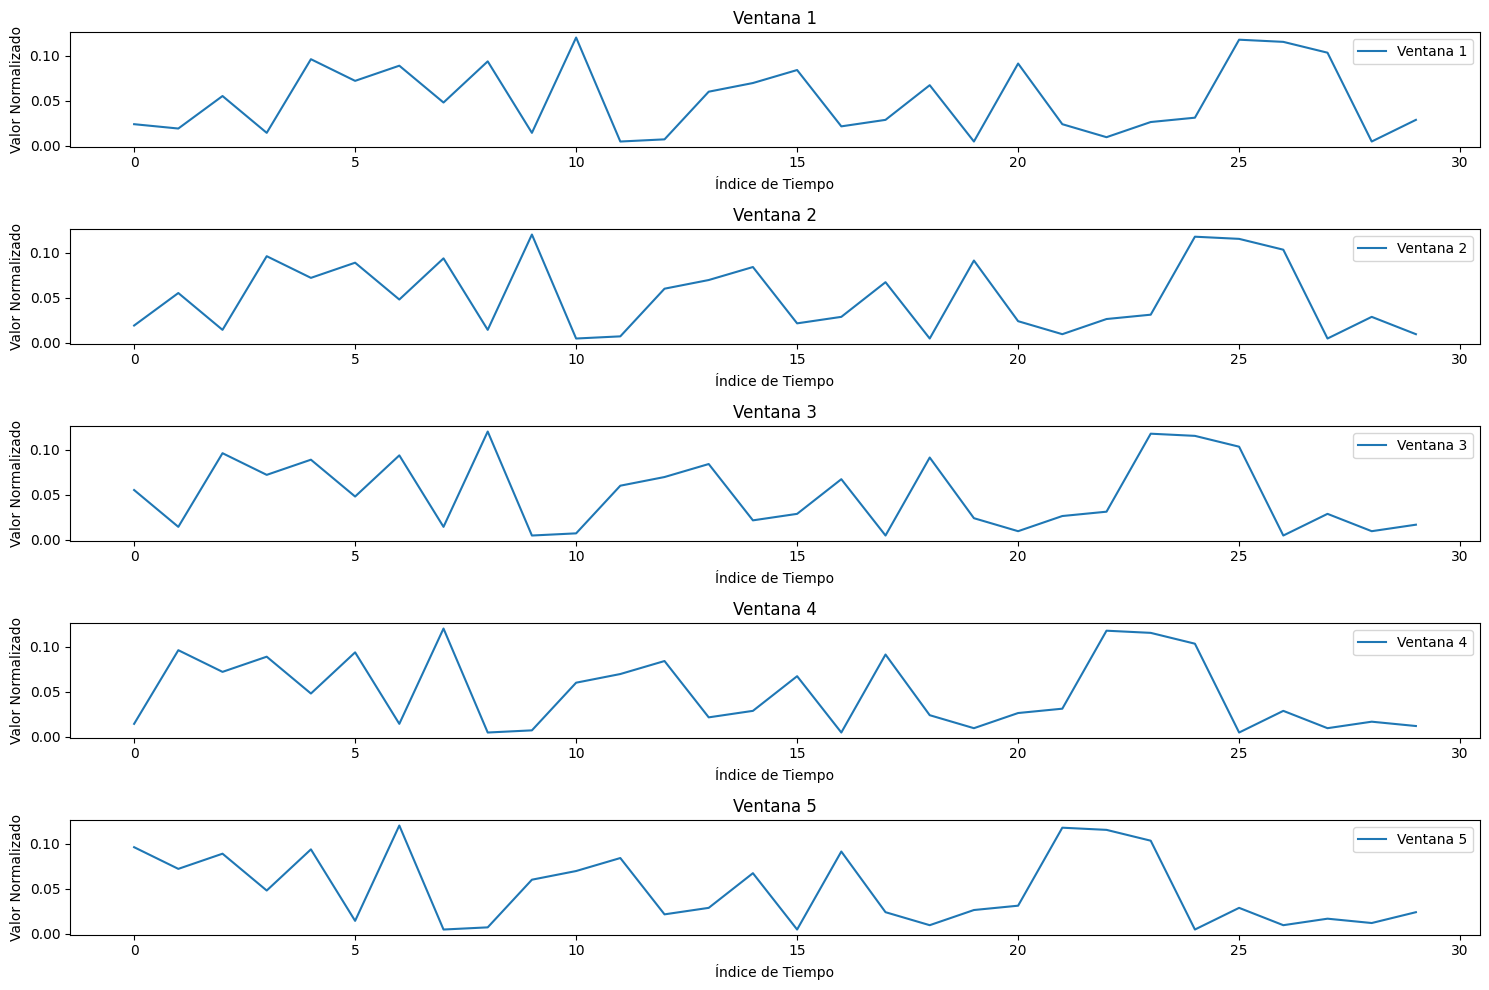

Tamaño del conjunto de entrenamiento: 1030 ventanas
Tamaño del conjunto de prueba: 258 ventanas


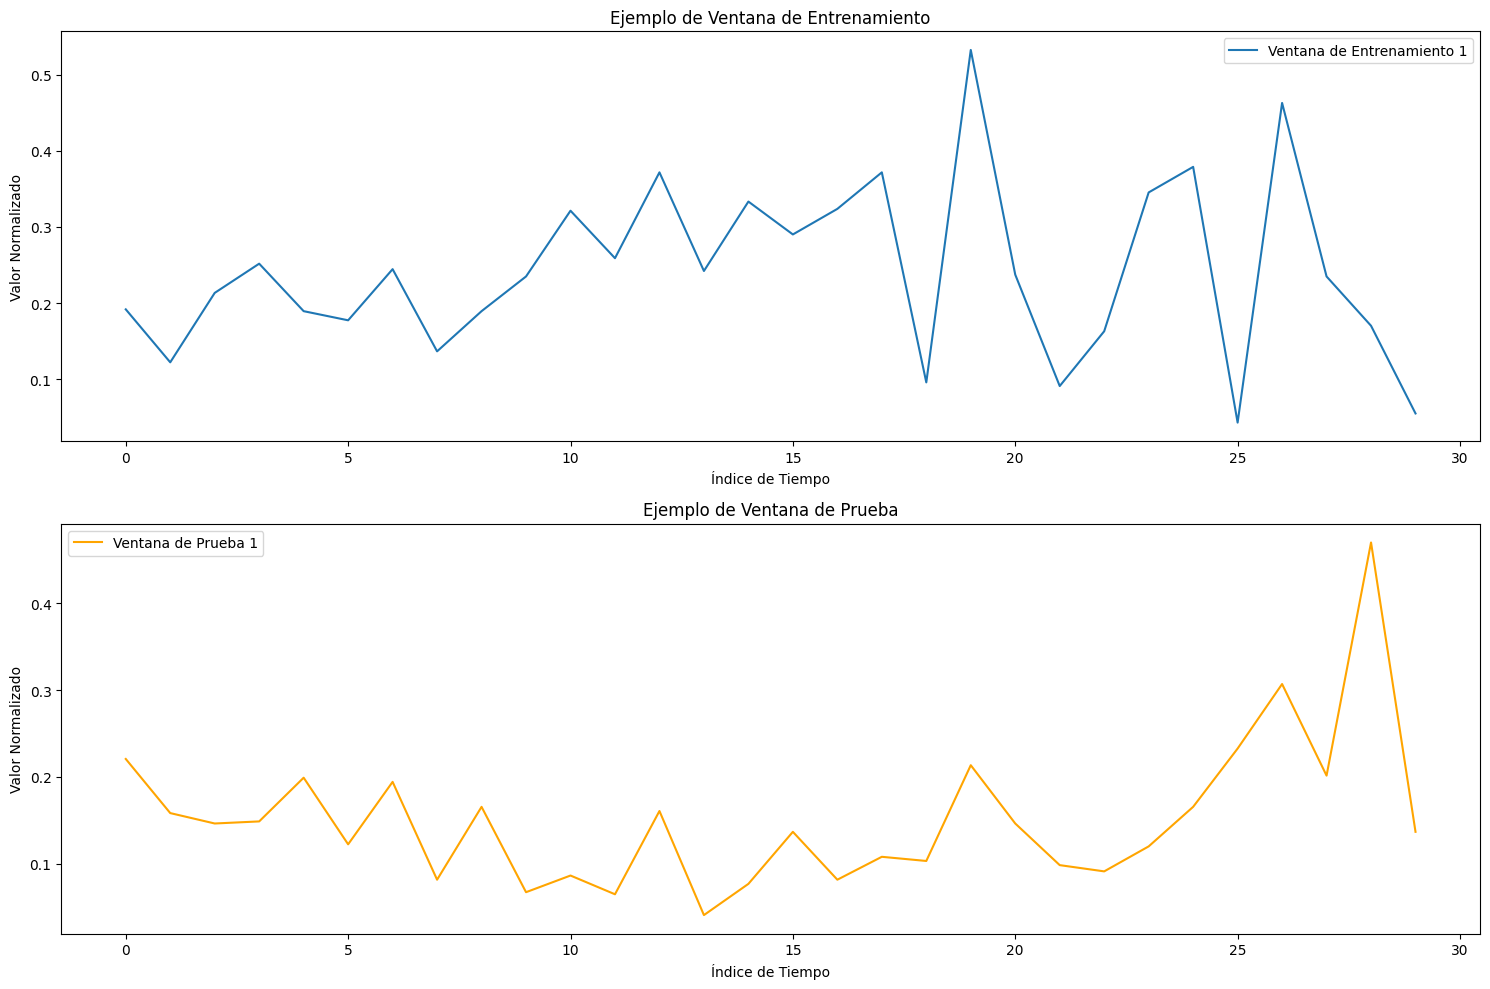

Epoch [10/200], d_loss: 1.3832, g_loss: 1.1930
Epoch [20/200], d_loss: 1.3627, g_loss: 1.0424
Epoch [30/200], d_loss: 1.4400, g_loss: 1.2089
Epoch [40/200], d_loss: 1.3604, g_loss: 0.7036
Epoch [50/200], d_loss: 1.4000, g_loss: 0.9770
Epoch [60/200], d_loss: 1.3935, g_loss: 0.9317
Early stopping triggered at epoch 60


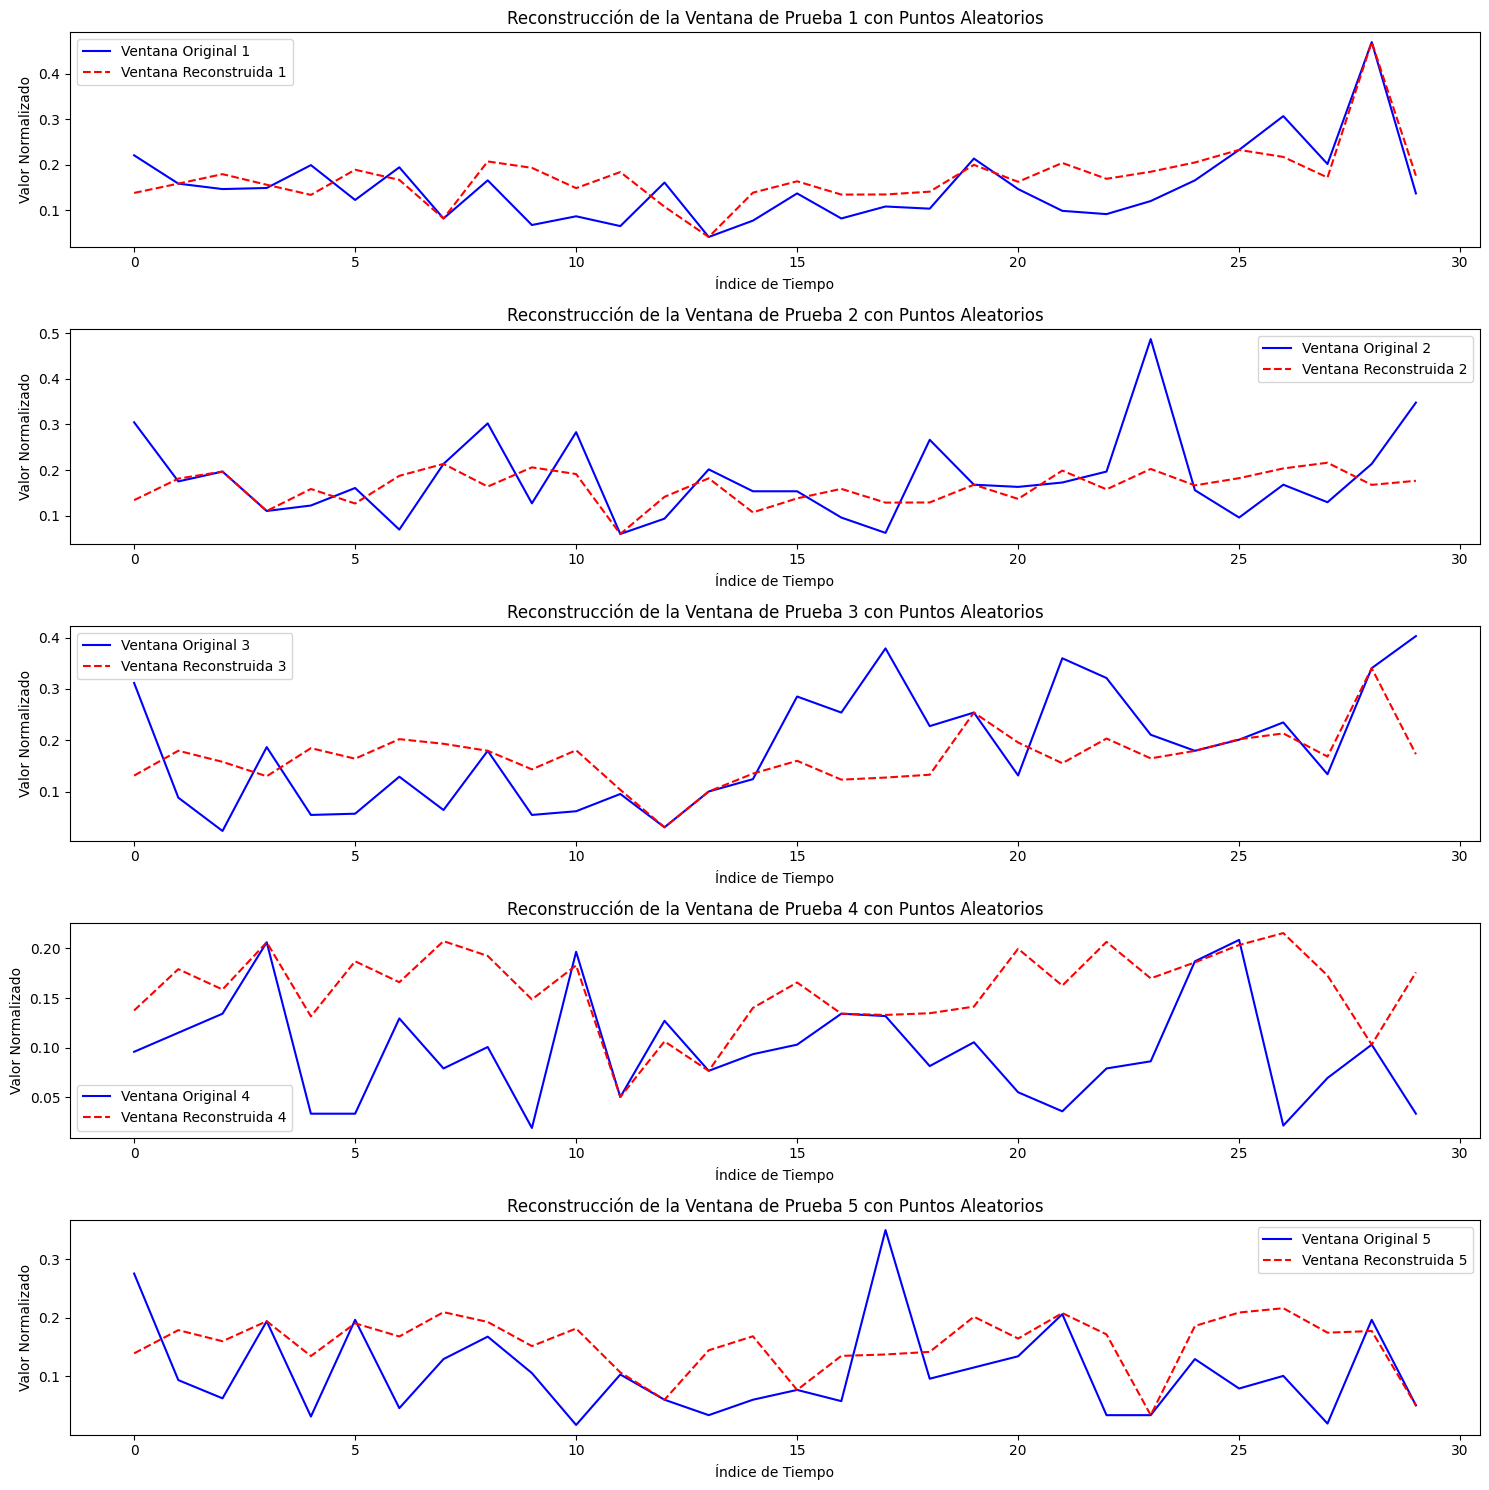

In [ ]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# Se cargan los datos de la empresa
file_path = '/content/Consolidada_depurada.xlsx'
df_plasticos = pd.read_excel(file_path)

# Tomar los datos Fecha
df_plasticos['FECHA'] = pd.to_datetime(df_plasticos['FECHA'])
df_plasticos = df_plasticos.sort_values('FECHA')

# Escalar los datos
x = df_plasticos['Cantidad'].values
x_min, x_max = x.min(), x.max()
x_normalized = (x - x_min) / (x_max - x_min)

# Visualizar los datos originales
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.title("Datos Originales")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Crear subconjuntos de entrenamiento con ventanas deslizantes específicas para reconstrucción
def create_training_data(series, window_size):
    X = []
    for start in range(len(series) - window_size + 1):
        window = series[start: start + window_size]
        X.append(window)
    return np.array(X)

# Utilizar los datos normalizados de la serie temporal real
time_series = x_normalized

# Definir el tamaño de las ventanas
window_size = 30  # Tamaño de la ventana (por ejemplo, 30 puntos consecutivos)

# Generar múltiples ventanas a lo largo de la serie
X = create_training_data(time_series, window_size)

# Graficar las primeras 5 ventanas
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(range(window_size), X[i], label=f"Ventana {i + 1}")
    plt.title(f"Ventana {i + 1}")
    plt.xlabel("Índice de Tiempo")
    plt.ylabel("Valor Normalizado")
    plt.tight_layout()
    plt.legend()
plt.show()

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Verificar el tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} ventanas")
print(f"Tamaño del conjunto de prueba: {len(X_test)} ventanas")

# Graficar algunas ventanas del conjunto de entrenamiento y prueba
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(range(window_size), X_train[0], label="Ventana de Entrenamiento 1")
plt.title("Ejemplo de Ventana de Entrenamiento")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Valor Normalizado")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(window_size), X_test[0], label="Ventana de Prueba 1", color='orange')
plt.title("Ejemplo de Ventana de Prueba")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Valor Normalizado")
plt.legend()

plt.tight_layout()
plt.show()

# Paso 1: Definir las arquitecturas del modelo GAN

# Generador: toma unos pocos puntos de entrada y genera una reconstrucción completa
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_layers=2):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Discriminador: toma una serie temporal generada o real y determina si es auténtica
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Inicializar modelos, optimizadores y funciones de pérdida
input_dim = 1
output_dim = window_size - 5
generator = Generator(input_dim=input_dim, output_dim=output_dim)
discriminator = Discriminator(input_dim=1)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0005)
loss_function = nn.BCELoss()
loss_function_mse = nn.MSELoss()

# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=20, min_delta=1e-4)

# Preparar los datos para entrenamiento
# Usar 5 puntos aleatorios como entrada y los restantes 25 puntos como objetivo
X_train_inputs = []
X_train_outputs = []
for window in X_train:
    indices = sorted(random.sample(range(window_size), 5))  # Seleccionar 5 índices aleatorios
    input_points = window[indices]
    mask = np.ones(window_size, dtype=bool)
    mask[indices] = False
    output_points = window[mask]
    X_train_inputs.append(input_points)
    X_train_outputs.append(output_points)

X_train_inputs = np.array(X_train_inputs)
X_train_outputs = np.array(X_train_outputs)

# Convertir los datos a tensores de PyTorch
X_train_inputs = torch.tensor(X_train_inputs, dtype=torch.float32).view(-1, 5, 1)
X_train_outputs = torch.tensor(X_train_outputs, dtype=torch.float32).view(-1, output_dim)

# Ciclo de entrenamiento para GAN
num_epochs = 200
for epoch in range(num_epochs):
    # Entrenar el Discriminador
    optimizer_D.zero_grad()
    real_labels = torch.ones(X_train_inputs.size(0), 1)
    fake_labels = torch.zeros(X_train_inputs.size(0), 1)

    # Entrenamiento con datos reales
    real_data = X_train_outputs.view(-1, output_dim, 1)
    real_outputs = discriminator(real_data)
    d_loss_real = loss_function(real_outputs, real_labels)

    # Entrenamiento con datos falsos generados
    z = X_train_inputs
    fake_data = generator(z).view(-1, output_dim, 1)
    fake_outputs = discriminator(fake_data)
    d_loss_fake = loss_function(fake_outputs, fake_labels)

    # Calcular la pérdida total y actualizar el discriminador
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    # Entrenar el Generador
    optimizer_G.zero_grad()
    fake_data = generator(z).view(-1, output_dim, 1)
    fake_outputs = discriminator(fake_data)
    g_loss_adversarial = loss_function(fake_outputs, real_labels)
    g_loss_mse = loss_function_mse(fake_data.squeeze(-1), X_train_outputs) * 10  # Aumentar el peso de la pérdida MSE
    g_loss = g_loss_adversarial + g_loss_mse
    g_loss.backward()
    optimizer_G.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Verificar si el entrenamiento debe detenerse por early stopping
    if early_stopping.should_stop(g_loss.item()):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# Paso 2: Probar la reconstrucción en varias ventanas de prueba
model.eval()
plt.figure(figsize=(15, 15))
for i in range(5):  # Probar con las primeras 5 ventanas de prueba
    with torch.no_grad():
        # Seleccionar una ventana de prueba y darle 5 puntos aleatorios
        test_indices = sorted(random.sample(range(window_size), 5))
        test_input_points = X_test[i, test_indices]
        test_mask = np.ones(window_size, dtype=bool)
        test_mask[test_indices] = False
        # Convertir a tensor de PyTorch
        test_input = torch.tensor(test_input_points, dtype=torch.float32).view(1, 5, 1)
        # Reconstruir el resto de la ventana
        reconstructed_output = generator(test_input).numpy().flatten()
        # Reconstruir la serie completa (los 5 puntos conocidos + los reconstruidos)
        reconstructed_series = np.zeros(window_size)
        reconstructed_series[test_indices] = test_input_points
        reconstructed_series[test_mask] = reconstructed_output

        # Graficar la ventana original y la reconstruida
        plt.subplot(5, 1, i + 1)
        plt.plot(range(window_size), X_test[i], label=f"Ventana Original {i+1}", color='blue')
        plt.plot(range(window_size), reconstructed_series, label=f"Ventana Reconstruida {i+1}", linestyle='--', color='red')
        plt.title(f"Reconstrucción de la Ventana de Prueba {i+1} con Puntos Aleatorios")
        plt.xlabel("Índice de Tiempo")
        plt.ylabel("Valor Normalizado")
        plt.legend()

plt.tight_layout()
plt.show()


# Modelo 4

Se construy´o una GAN (Red Generativa Adversarial) utilizando PyTorch para la interpolación de una serie temporal de producción plástica, con LSTMs en el generador y discriminador para capturar la naturaleza temporal de los datos. Primero, los datos históricos de producción ('Cantidad') se normalizan para su entrenamiento. Se utilizan ventanas deslizantes de 30 días (input_length = 30) para generar conjuntos de datos de entrada y salida, lo cual permite entrenar el modelo en secuencias temporales con el fin de aprender la dinámica de los datos.

El generador (Generator) toma una secuencia de entrada de longitud fija y genera una predicción para los próximos 30 días. Esta red tiene una estructura LSTM seguida de capas lineales que aplican funciones de activación no lineales (ReLU y Tanh) para producir valores normalizados que representan las cantidades futuras.

El discriminador (Discriminator), también basado en una LSTM seguida de capas lineales, evalúa si una secuencia dada es real (proveniente de los datos originales) o falsa (generada). Utiliza la función de activación Sigmoid para producir una probabilidad que indica la autenticidad de la secuencia.

Durante el entrenamiento, se actualizan alternativamente el generador y el discriminador. El discriminador se entrena primero para diferenciar entre secuencias reales y generadas, mientras que el generador se entrena para engañar al discriminador. Además de la pérdida adversarial (BCELoss), el generador también minimiza la pérdida MSE (MSELoss) entre las secuencias generadas y las secuencias reales, mejorando así la precisión de la reconstrucción de la serie temporal. El entrenamiento implementa "early stopping" para evitar el sobreajuste, deteniéndose si la mejora en la pérdida es mínima durante varias épocas consecutivas.

Finalmente, la función reconstruir_rango_fechas() permite generar una interpolación en un rango especificado por el usuario. La reconstrucción se realiza generando puntos faltantes secuencialmente, utilizando el generador entrenado, y añadiendo estos puntos generados a los datos originales. Esta función también muestra gráficamente los datos originales y reconstruidos, y calcula métricas de precisión como MSE, MAE y el R2 para evaluar la calidad de la interpolación.

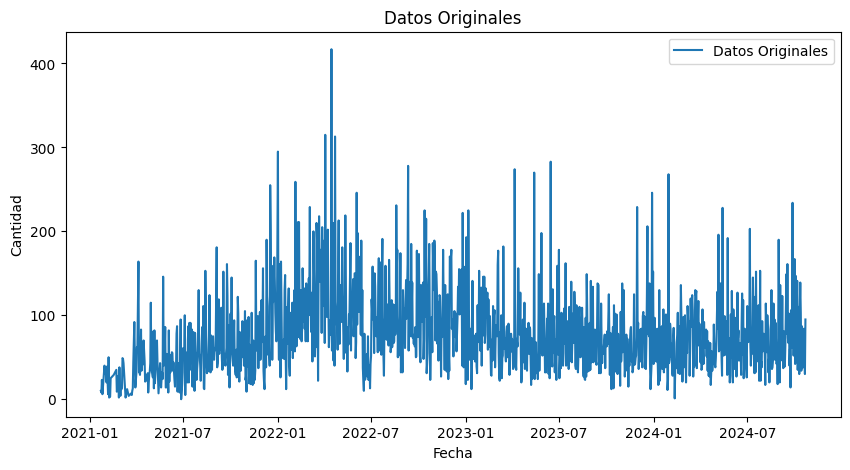

Epoch [10/500], d_loss: 1.3816, g_loss: 1.1172
Epoch [20/500], d_loss: 1.3907, g_loss: 0.9226
Epoch [30/500], d_loss: 1.3850, g_loss: 0.8589
Epoch [40/500], d_loss: 1.3894, g_loss: 0.8219
Epoch [50/500], d_loss: 1.3871, g_loss: 0.8285
Epoch [60/500], d_loss: 1.3866, g_loss: 0.8322
Early stopping triggered at epoch 62


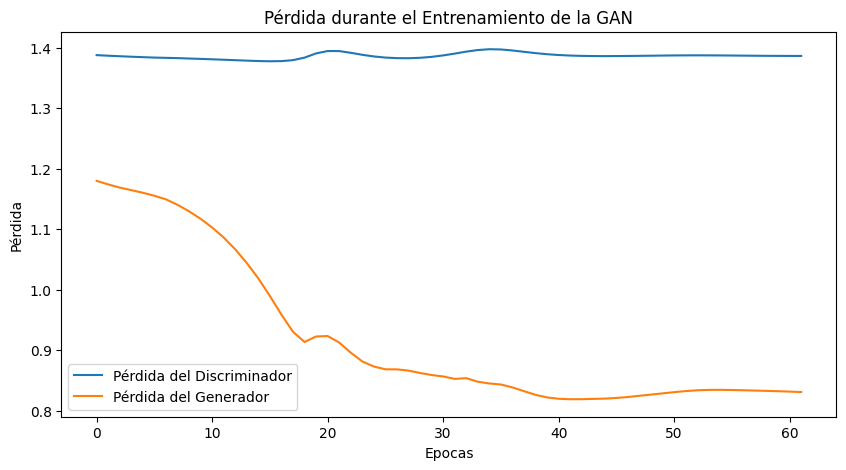

Ingrese la fecha de inicio (YYYY-MM-DD): 2021-01-01
Ingrese la fecha de fin (YYYY-MM-DD): 2021-04-01


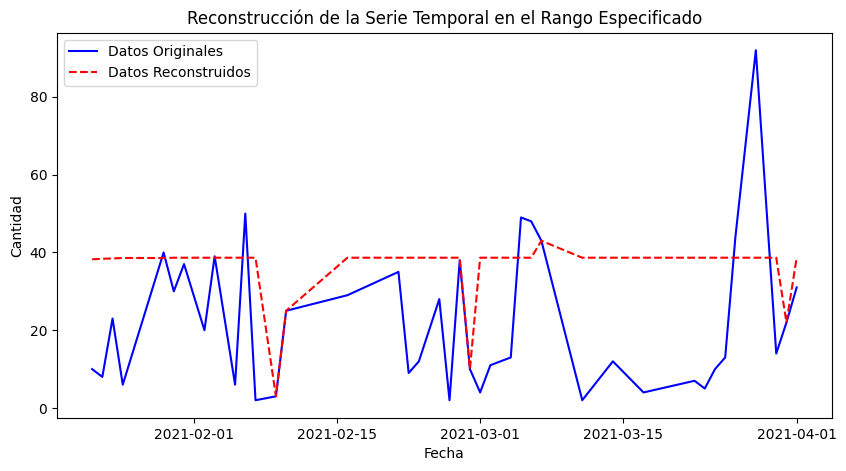

MSE: 559.0296
MAE: 18.7929
R2 Score: -0.5860


In [ ]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# Utilizar los datos de la empresa
file_path = '/content/Consolidada_depurada.xlsx'
df_plasticos = pd.read_excel(file_path)

# Tomar los datos de Fecha
df_plasticos['FECHA'] = pd.to_datetime(df_plasticos['FECHA'])
df_plasticos = df_plasticos.sort_values('FECHA')

# Escalar los datos
x = df_plasticos['Cantidad'].values
x_min, x_max = x.min(), x.max()
x_normalized = (x - x_min) / (x_max - x_min)

# Visualizar los datos originales
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.title("Datos Originales")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Crear subconjuntos de entrenamiento con ventanas deslizantes específicas
def create_training_data(series, input_length, output_length):
    X, y = [], []
    for start in range(0, len(series) - input_length - output_length + 1):
        input_seq = series[start: start + input_length]
        output_seq = series[start + input_length: start + input_length + output_length]
        X.append(input_seq)
        y.append(output_seq)
    return np.array(X), np.array(y)

# Utilizar los datos normalizados de la serie temporal real
time_series = x_normalized

# Actualizar el enfoque para usar ventanas deslizantes para el entrenamiento
input_length = 30  # Tamaño de la ventana de entrada
output_length = 30  # Reconstruir una ventana completa siguiente

# Crear subconjuntos de entrenamiento con ventanas deslizantes
X, y = create_training_data(time_series, input_length, output_length)

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir los datos a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, input_length, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, output_length, 1)
X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, input_length, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, output_length, 1)

# Definir clases de generador y discriminador para GAN mejorada con LSTM
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_layers=2):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Inicializar modelos, optimizadores y funciones de pérdida
input_dim = 1
output_dim = output_length
generator = Generator(input_dim=input_dim, output_dim=output_dim)
discriminator = Discriminator(input_dim=1)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005)  # Reducir la tasa de aprendizaje para mejorar la estabilidad
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0005)
loss_function = nn.BCELoss()
loss_function_mse = nn.MSELoss()

# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=20, min_delta=1e-4)

# Ciclo de entrenamiento
num_epochs = 500
metrics = {'d_loss': [], 'g_loss': []}

for epoch in range(num_epochs):
    # Entrenar el Discriminador
    optimizer_D.zero_grad()
    real_labels = torch.ones(X_train.size(0), 1)
    fake_labels = torch.zeros(X_train.size(0), 1)
    real_data = y_train
    real_outputs = discriminator(real_data)
    d_loss_real = loss_function(real_outputs, real_labels)
    z = X_train
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    d_loss_fake = loss_function(fake_outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    # Entrenar el Generador
    optimizer_G.zero_grad()
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    g_loss_adversarial = loss_function(fake_outputs, real_labels)
    g_loss_mse = loss_function_mse(fake_data.squeeze(-1), y_train.view(-1, output_length)) * 10
    g_loss = g_loss_adversarial + g_loss_mse
    g_loss.backward()
    optimizer_G.step()

    # Almacenar las métricas de pérdida
    metrics['d_loss'].append(d_loss.item())
    metrics['g_loss'].append(g_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Verificar si el entrenamiento debe detenerse por early stopping
    if early_stopping.should_stop(g_loss.item()):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# Graficar las métricas de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(metrics['d_loss'], label='Pérdida del Discriminador')
plt.plot(metrics['g_loss'], label='Pérdida del Generador')
plt.title('Pérdida durante el Entrenamiento de la GAN')
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Función para reconstruir los valores en un rango de fechas dado por el usuario
def reconstruir_rango_fechas(generator, df, puntos_entrada=5):
    # Solicitar al usuario las fechas de inicio y fin
    fecha_inicio = input("Ingrese la fecha de inicio (YYYY-MM-DD): ")
    fecha_fin = input("Ingrese la fecha de fin (YYYY-MM-DD): ")

    # Filtrar los datos en el rango de fechas dado
    df_filtrado = df[(df['FECHA'] >= fecha_inicio) & (df['FECHA'] <= fecha_fin)]
    if len(df_filtrado) < puntos_entrada:
        raise ValueError("No hay suficientes puntos de datos en el rango especificado para los puntos de entrada requeridos.")

    # Normalizar los datos filtrados
    x_filtrado = df_filtrado['Cantidad'].values
    x_filtrado_normalized = (x_filtrado - x_min) / (x_max - x_min)

    # Seleccionar puntos de entrada al azar
    puntos_indices = sorted(random.sample(range(len(x_filtrado_normalized)), puntos_entrada))
    input_data = x_filtrado_normalized[puntos_indices]
    input_tensor = torch.tensor(input_data, dtype=torch.float32).view(1, -1, 1)

    # Generar la reconstrucción completa usando el generador entrenado
    reconstruccion_completa = []
    with torch.no_grad():
        for i in range(len(x_filtrado)):
            if i in puntos_indices:
                reconstruccion_completa.append(x_filtrado[i])  # Usar el valor original conocido
            else:
                output_tensor = generator(input_tensor)
                output_value = output_tensor.numpy().flatten()[0]  # Obtener el primer valor generado
                output_value_denormalized = output_value * (x_max - x_min) + x_min
                reconstruccion_completa.append(output_value_denormalized)
                # Añadir el valor generado como nuevo punto de entrada
                input_tensor = torch.cat((input_tensor[:, 1:, :], torch.tensor([[output_value]], dtype=torch.float32).view(1, -1, 1)), dim=1)

    # Graficar los resultados junto con la serie original
    fechas_reconstruccion = df_filtrado['FECHA']
    plt.figure(figsize=(10, 5))
    plt.plot(fechas_reconstruccion, x_filtrado, label="Datos Originales", color='blue')
    plt.plot(fechas_reconstruccion, reconstruccion_completa, label="Datos Reconstruidos", linestyle='--', color='red')
    plt.title("Reconstrucción de la Serie Temporal en el Rango Especificado")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.show()

    # Calcular y mostrar métricas de reconstrucción
    mse = mean_squared_error(x_filtrado, reconstruccion_completa)
    mae = mean_absolute_error(x_filtrado, reconstruccion_completa)
    r2 = r2_score(x_filtrado, reconstruccion_completa)
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

# Ejemplo de uso de la función de reconstrucción
reconstruir_rango_fechas(generator, df_plasticos, puntos_entrada=5)

# MÓDULO 5

In [ ]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar los datos desde el archivo proporcionado
file_path = '/content/Consolidada_depurada.xlsx'
df_plasticos = pd.read_excel(file_path)

# Preprocesar los datos
df_plasticos['FECHA'] = pd.to_datetime(df_plasticos['FECHA'])
df_plasticos = df_plasticos.sort_values('FECHA')
x = df_plasticos['Cantidad'].values
x_min, x_max = x.min(), x.max()
x_normalized = (x - x_min) / (x_max - x_min)

# Visualizar los datos originales
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.title("Datos Originales")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Crear conjuntos de datos para reconstrucción como R-GAN
def create_masked_data(series, mask_size=10):
    X, y = [], []
    for i in range(mask_size, len(series) - mask_size):
        context = np.concatenate([series[i - mask_size:i], series[i + 1:i + 1 + mask_size]])
        X.append(context)  # Contexto de la serie
        y.append(series[i])  # Punto enmascarado
    return np.array(X), np.array(y)

# Generar los datos de entrenamiento y prueba
mask_size = 20
X, y = create_masked_data(x_normalized, mask_size=mask_size)
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Visualizar algunos ejemplos de los conjuntos de entrenamiento
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(range(len(X_train[i])), X_train[i], label=f"Contexto {i + 1}")
plt.title("Ejemplos de Datos de Entrenamiento (Contexto)")
plt.xlabel("Índice del Contexto")
plt.ylabel("Valores Normalizados")
plt.legend()
plt.show()

# Definir el generador y discriminador
class GeneratorLSTM(nn.Module):
    def __init__(self, input_dim, noise_dim, output_dim, hidden_dim=512):
        super(GeneratorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim + noise_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Tanh()
        )

    def forward(self, x, noise):
        x = torch.cat((x, noise), dim=2)  # Concatenar contexto y ruido
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.fc(x)
        return out

# Inicializar modelos
input_dim = X_train.size(1)
noise_dim = 10

generator = GeneratorLSTM(input_dim=input_dim, noise_dim=noise_dim, output_dim=1)
discriminator = Discriminator(input_dim=1)

# Definir optimizadores y funciones de pérdida
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001)
loss_function = nn.BCELoss()
loss_function_mse = nn.MSELoss()

# Entrenamiento de la GAN
num_epochs = 1000
early_stopping_patience = 50
best_g_loss = float('inf')
stopping_step = 0

metrics = {'d_loss': [], 'g_loss': []}  # Almacenar las métricas de pérdida

for epoch in range(num_epochs):
    # Entrenar el discriminador
    optimizer_D.zero_grad()
    real_labels = torch.ones(y_train.size(0), 1)
    fake_labels = torch.zeros(y_train.size(0), 1)
    real_outputs = discriminator(y_train)
    d_loss_real = loss_function(real_outputs, real_labels)

    noise = torch.randn(X_train.size(0), 1, noise_dim)
    fake_data = generator(X_train.unsqueeze(1), noise).view(-1, 1)
    fake_outputs = discriminator(fake_data)
    d_loss_fake = loss_function(fake_outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    # Entrenar el generador
    optimizer_G.zero_grad()
    noise = torch.randn(X_train.size(0), 1, noise_dim)
    fake_data = generator(X_train.unsqueeze(1), noise).view(-1, 1)
    fake_outputs = discriminator(fake_data)
    g_loss_adversarial = loss_function(fake_outputs, real_labels)
    g_loss_mse = loss_function_mse(fake_data, y_train) * 50  # Ajustar peso de MSE
    g_loss = g_loss_adversarial + g_loss_mse
    g_loss.backward()
    optimizer_G.step()

    metrics['d_loss'].append(d_loss.item())
    metrics['g_loss'].append(g_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Early stopping
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        stopping_step = 0
    else:
        stopping_step += 1

    if stopping_step >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# Graficar las métricas de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(metrics['d_loss'], label='Pérdida del Discriminador')
plt.plot(metrics['g_loss'], label='Pérdida del Generador')
plt.title('Pérdidas durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Reconstrucción de la serie temporal
with torch.no_grad():
    noise = torch.randn(X_train.size(0), 1, noise_dim)
    reconstructed_data = generator(X_train.unsqueeze(1), noise).view(-1).detach().numpy()
    reconstructed_data = reconstructed_data * (x_max - x_min) + x_min

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.plot(df_plasticos['FECHA'][mask_size:-mask_size], reconstructed_data, label="Datos Reconstruidos", linestyle='--', color='red')
plt.title("Reconstrucción Completa de la Serie Temporal con R-GAN Mejorada")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Evaluar las métricas
mse = mean_squared_error(x[mask_size:-mask_size], reconstructed_data)
mae = mean_absolute_error(x[mask_size:-mask_size], reconstructed_data)
r2 = r2_score(x[mask_size:-mask_size], reconstructed_data)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Modelo 6

In [ ]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# Cargar los datos desde el excel de la empresa
file_path = '/content/Consolidada_depurada.xlsx'
df_plasticos = pd.read_excel(file_path)

# Datos ordenados por fecha
df_plasticos['FECHA'] = pd.to_datetime(df_plasticos['FECHA'])
df_plasticos = df_plasticos.sort_values('FECHA')

# Escalar los datos
x = df_plasticos['Cantidad'].values
x_min, x_max = x.min(), x.max()
x_normalized = (x - x_min) / (x_max - x_min)

# Crear subconjuntos de entrenamiento con ventanas deslizantes específicas
def create_training_data(series, input_length, output_length):
    X, y = [], []
    for start in range(0, len(series) - input_length + 1):
        input_seq = series[start: start + input_length]
        output_seq = series[start + input_length: start + input_length + output_length]
        if len(output_seq) == output_length:
            X.append(input_seq)
            y.append(output_seq)
    return np.array(X), np.array(y)

# Utilizar los datos normalizados de la serie temporal real
time_series = x_normalized

# Definir el tamaño de las ventanas de entrada y salida
input_length = 30
output_length = len(time_series) - input_length
X, y = create_training_data(time_series, input_length, output_length)

# Asegurarse de tener solo una ventana de entrada para la reconstrucción completa
X_train = X[:1]
y_train = y[:1]

# Convertir los datos a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, input_length, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, output_length, 1)

# Definir clases de generador y discriminador para GAN mejorada con LSTM
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_layers=2):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Inicializar modelos, optimizadores y funciones de pérdida
input_dim = 1
output_dim = output_length
generator = Generator(input_dim=input_dim, output_dim=output_dim)
discriminator = Discriminator(input_dim=1)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0005)
loss_function = nn.BCELoss()
loss_function_mse = nn.MSELoss()

# Implementación de Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=20, min_delta=1e-4)

# Ciclo de entrenamiento
num_epochs = 500
metrics = {'d_loss': [], 'g_loss': []}

for epoch in range(num_epochs):
    # Entrenar el Discriminador
    optimizer_D.zero_grad()
    real_labels = torch.ones(X_train.size(0), 1)
    fake_labels = torch.zeros(X_train.size(0), 1)
    real_data = y_train
    real_outputs = discriminator(real_data)
    d_loss_real = loss_function(real_outputs, real_labels)
    z = X_train
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    d_loss_fake = loss_function(fake_outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    # Entrenar el Generador
    optimizer_G.zero_grad()
    fake_data = generator(z).view(-1, output_length, 1)
    fake_outputs = discriminator(fake_data)
    g_loss_adversarial = loss_function(fake_outputs, real_labels)
    g_loss_mse = loss_function_mse(fake_data.squeeze(-1), y_train.view(-1, output_length)) * 10
    g_loss = g_loss_adversarial + g_loss_mse
    g_loss.backward()
    optimizer_G.step()

    # Almacenar las métricas de pérdida
    metrics['d_loss'].append(d_loss.item())
    metrics['g_loss'].append(g_loss.item())

    if early_stopping.should_stop(g_loss.item()):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

# Graficar las métricas de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(metrics['d_loss'], label='Pérdida del Discriminador')
plt.plot(metrics['g_loss'], label='Pérdida del Generador')
plt.title('Pérdida durante el Entrenamiento de la GAN')
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Validación del modelo
with torch.no_grad():
    z_test = X_train
    reconstructed_data = generator(z_test).detach().numpy().flatten()
    reconstructed_data = reconstructed_data * (x_max - x_min) + x_min

    # Graficar los resultados
    plt.figure(figsize=(10, 5))
    plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
    plt.plot(df_plasticos['FECHA'][input_length:input_length + output_length],
             reconstructed_data, label="Datos Reconstruidos", linestyle='--', color='red')
    plt.title("Reconstrucción Completa de la Serie Temporal usando GAN")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.show()

    # Evaluar las métricas para la reconstrucción
    y_true = x[input_length:input_length + output_length]
    mse = mean_squared_error(y_true, reconstructed_data)
    mae = mean_absolute_error(y_true, reconstructed_data)
    r2 = r2_score(y_true, reconstructed_data)

    print(f"MSE en datos de prueba: {mse:.4f}")
    print(f"MAE en datos de prueba: {mae:.4f}")
    print(f"R2 Score en datos de prueba: {r2:.4f}")

# Modelo 7

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

# Cargar los datos desde el archivo proporcionado
file_path = '/content/Consolidada_depurada.xlsx'
df_plasticos = pd.read_excel(file_path)

# Preprocesar los datos
df_plasticos['FECHA'] = pd.to_datetime(df_plasticos['FECHA'])
df_plasticos = df_plasticos.sort_values('FECHA')
x = df_plasticos['Cantidad'].values
x_min, x_max = x.min(), x.max()
x_normalized = 2 * (x - x_min) / (x_max - x_min) - 1  # Normalizar entre -1 y 1

# Visualizar los datos originales
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x, label="Datos Originales")
plt.title("Datos Originales")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Crear ventanas deslizantes
window_size = 50
stride = 10
subseries = []
for i in range(0, len(x_normalized) - window_size, stride):
    subseries.append(x_normalized[i:i + window_size])
subseries = np.array(subseries)

# Definir las dimensiones
input_dim = window_size
latent_dim = 100

# Generador con LSTM
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(latent_dim, 256, batch_first=True, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.unsqueeze(1)  # Agregar dimensión temporal
        lstm_out, _ = self.lstm(z)
        output = self.fc(lstm_out[:, -1, :])  # Usar la última salida de LSTM
        return output

# Discriminador con LSTM
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, 256, batch_first=True, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Agregar dimensión temporal
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Usar la última salida de LSTM
        return output

# Instanciar modelos
generator = Generator()
discriminator = Discriminator()

# Optimizadores
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0005)
optim_dis = torch.optim.Adam(discriminator.parameters(), lr=0.0005)

# Pérdida
criterion = nn.BCELoss()

# Preparar los datos para entrenamiento
subseries_tensor = torch.tensor(subseries, dtype=torch.float32)

# Entrenamiento
num_epochs = 1000
batch_size = 64
real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

for epoch in range(num_epochs):
    for i in range(0, len(subseries_tensor) - batch_size, batch_size):
        # Obtener batch real con ruido
        real_data = subseries_tensor[i:i + batch_size] + 0.05 * torch.randn_like(subseries_tensor[i:i + batch_size])

        # Generar datos falsos
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)

        # Entrenar discriminador
        real_pred = discriminator(real_data)
        fake_pred = discriminator(fake_data.detach())
        loss_real = criterion(real_pred, real_labels)
        loss_fake = criterion(fake_pred, fake_labels)
        loss_dis = loss_real + loss_fake

        optim_dis.zero_grad()
        loss_dis.backward()
        optim_dis.step()

        # Entrenar generador
        fake_pred = discriminator(fake_data)
        loss_gen = criterion(fake_pred, real_labels)

        optim_gen.zero_grad()
        loss_gen.backward()
        optim_gen.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss Gen: {loss_gen.item()}, Loss Dis: {loss_dis.item()}")

# Reconstrucción de la serie completa
reconstructed_series = []
for i in range(0, len(x_normalized) - window_size, stride):
    z = torch.randn(1, latent_dim)
    generated_window = generator(z).detach().numpy().flatten()
    reconstructed_series.append(generated_window)

# Combinar ventanas reconstruidas
reconstructed_series = np.concatenate(reconstructed_series)
reconstructed_series = (reconstructed_series + 1) / 2 * (x_max - x_min) + x_min  # Desnormalizar

# Asegurar que las longitudes coincidan
min_length = min(len(reconstructed_series), len(df_plasticos['FECHA']))
reconstructed_series = reconstructed_series[:min_length]
df_plasticos = df_plasticos.iloc[:min_length]

# Evaluar la reconstrucción
mse = mean_squared_error(x[:min_length], reconstructed_series)
print(f"Error Cuadrático Medio (MSE): {mse}")

# Visualizar la serie reconstruida
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], reconstructed_series, label="Serie Reconstruida")
plt.plot(df_plasticos['FECHA'], x[:min_length], label="Datos Originales", alpha=0.5)
plt.title("Serie Original vs. Reconstruida")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

# Visualizar diferencias
plt.figure(figsize=(10, 5))
plt.plot(df_plasticos['FECHA'], x[:min_length] - reconstructed_series, label="Diferencias")
plt.title("Diferencias entre Serie Original y Reconstruida")
plt.xlabel("Fecha")
plt.ylabel("Diferencia")
plt.legend()
plt.show()